In [3]:
# Classification de texturas; LBP
# Punto y miras alrededor y debes identificar las esquinas, bordes,
# si es plano, mirando la intensidad
# Cuantos LBP de cada tipo en una imagen tiene, sacas una distribution y con base en eso,
# comparas y sacas una conclusión de un histograma
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
from tensorflow.python.util.numpy_compat import np_asarray

In [4]:
# Ejemplo práctico de lo que hace el filtro
METHOD = "uniform"
plt.rcParams["font.size"] = 9
def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor="0.5")
    ax.add_patch(circle)

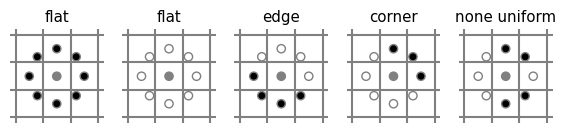

In [5]:
def plot_lbp_model(ax, binary_values):
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = "0.5"
    plot_circle(ax, (0,0), r, gray)
    for i, face_color in enumerate(binary_values):
        x = R * np.cos(i*theta)
        y = R * np.sin(i*theta)
        plot_circle(ax, (x,y), r, str(face_color))
    for x in np.linspace(-w, w, 4):
        ax.axvline(x,color=gray)
        ax.axhline(x, color=gray)
    ax.axis("image")
    ax.axis("off")
    size = w+0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)
fig, axis = plt.subplots(ncols=5, figsize=(7,2))
title = ["flat", "flat", "edge", "corner", "none uniform"]
binary_pattern = [
    np.zeros(8),
    np.ones(8),
    np.hstack([np.ones(4), np.zeros(4)]),
    np.hstack([np.zeros(3), np.ones(5)]),
    [1,0,0,1,1,1,0,0]
]
for ax, values, name in zip(axis, binary_pattern, title):
    plot_lbp_model(ax, values)
    ax.set_title(name)

In [6]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

radius = 3
npoints = 8*radius


In [7]:
def overlay_labels(image, lbp, labels): # Poder representar lo que estamos haciendo en rojo
    mask = np.logical_or.reduce([lbp==each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)

In [8]:
def highlight_bars(bars, indexes) : # Para que nos marque en rojo las partes del histograma
    for i in indexes:
        bars[i].set_facecolor("r")


In [9]:
image = data.brick()
lbp = local_binary_pattern(image,npoints, radius, method=METHOD)


In [10]:
def hist(ax,lbp):
    nbins = int(lbp.max()+1)
    return ax.hist(lbp.ravel(), density=True, bins=nbins, range=(0,nbins), facecolor="0.5")

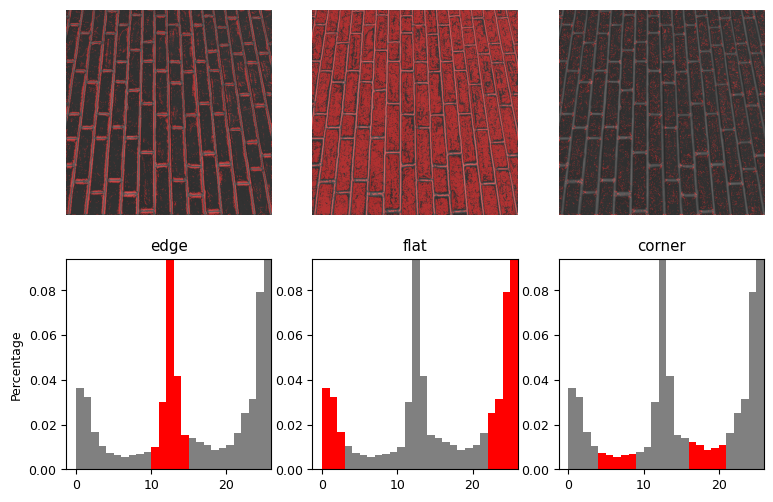

In [11]:
fig,(ax_image, ax_hist) =plt.subplots(nrows=2, ncols=3, figsize=(9,6))
plt.gray()
# Mirar imagen del ejemplo para entender los labels
titles = ("edge", "flat", "corner")
w = radius-1
edge_labels=range(npoints//2 - w, npoints//2 +w+1)
flat_labels = list(range(0, w+1)) + list(range(npoints-w, npoints+2))
i_14 = npoints//4
i_34 = 3*(npoints//4)
corners_labels = list(range(i_14-w, i_14+w+1)) + list(range(i_34-w, i_34+w+1))
labels_set = (edge_labels, flat_labels, corners_labels)
for ax, labels in zip(ax_image, labels_set):
    ax.imshow(overlay_labels(image, lbp, labels))
for ax, labels, name in zip(ax_hist, labels_set, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=npoints+2)
    ax.set_title(name)
ax_hist[0].set_ylabel("Percentage")
for ax in ax_image:
    ax.axis("off")

In [12]:
radius = 2
npoints = 8*radius

# Comparar histogramas, p histograma y q histograma de referencia
def kulback_leibler_divergence(p,q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p!=0, q!=0)
    return np.sum(p[filt]*np.log2(p[filt]/q[filt]))

def match(refs, image):
    best_score = 10
    best_name= None
    lbp = local_binary_pattern(image, npoints, radius, METHOD)
    nbins = int(lbp.max()+1)
    hist, _ = np.histogram(lbp, density= True, bins=nbins, range=(0,nbins))
    for name, ref in refs.items():
        refs_hist, _ = np.histogram(ref, density= True, bins=nbins, range=(0,nbins))
        score = kulback_leibler_divergence(hist, refs_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


In [13]:
import cv2
import glob

refs_image_lamp = cv2.imread("test/Imagen de WhatsApp 2025-04-23 a las 20.33.50_8624a043.jpg", 0)
refs_image_curtain = cv2.imread("test/Imagen de WhatsApp 2025-04-23 a las 19.50.50_7c3e1c6f.jpg", 0)
refs_image_rope = cv2.imread("test/Imagen de WhatsApp 2025-04-23 a las 20.33.48_aa6aa5bb.jpg", 0)
refs_image_floor = cv2.imread("test/Imagen de WhatsApp 2025-04-23 a las 19.50.55_5923eeab.jpg", 0)

refs = {
    "lamp": local_binary_pattern(refs_image_lamp,npoints,radius, METHOD),
    "curtain": local_binary_pattern(refs_image_curtain,npoints,radius, METHOD),
    "rope": local_binary_pattern(refs_image_rope,npoints,radius, METHOD),
    "floor": local_binary_pattern(refs_image_floor,npoints,radius, METHOD)
}
for imagePath in glob.glob("training/*.jpg"):
    image = cv2.imread(imagePath)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pred = match(refs, image_gray)
    cv2.putText(image, pred, (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 3)
    cv2.imshow("Prediccion", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


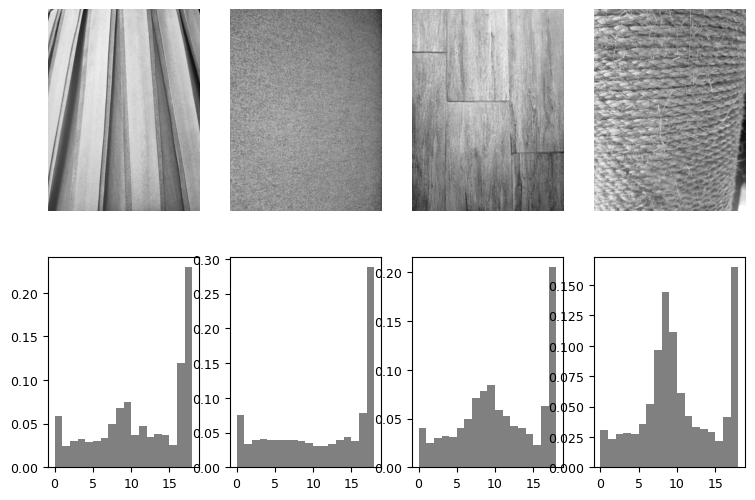

In [14]:
# PINTAR HISTOGRAMAS PARA VER PQ SE LIA ENTRE FLOOR, CURTAIN, LAMP
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(9,6))
plt.gray()
ax1.imshow(refs_image_lamp)
ax1.axis("off")
hist(ax5, refs["lamp"])
ax2.imshow(refs_image_curtain)
ax2.axis("off")
hist(ax6, refs["curtain"])
ax3.imshow(refs_image_floor)
ax3.axis("off")
hist(ax7, refs["floor"])
ax4.imshow(refs_image_rope)
ax4.axis("off")
hist(ax8, refs["rope"])
plt.show()